In [1]:
# TensorFlow e tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import random

import cv2 as cv
import glob

#from keras.utils import to_categorical

# Bibliotecas Auxiliares
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


In [2]:
def convert_image(full_path):
    
    width = 200
    height = 50
    
    #Load image by OpenCV
    img = cv.imread(full_path)

    #Resize to respect the input_shape
    inp = cv.resize(img, (width , height ))

    #Convert img to RGB
    rgb = cv.cvtColor(inp, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(inp, cv.COLOR_BGR2GRAY)

    #Is optional but i recommend (float convertion and convert img to tensor image)
    rgb_tensor = tf.convert_to_tensor(gray, dtype=tf.float32)

    #Add dims to rgb_tensor
    rgb_tensor = tf.expand_dims(rgb_tensor , 0)
    
    return gray

In [3]:
def return_dataset(path, label):
    files = glob.glob(path)           # get all the .txt files
    return files, [label for i in range(len(files))]
    width = 200
    height = 50

    images = []
    labels = []
    for file in files:                   # iterate over the list of files
        #print(file)

        #Load image by OpenCV
        img = cv.imread(file)

        #Resize to respect the input_shape
        inp = cv.resize(img, (width , height ))

        #Convert img to RGB
        rgb = cv.cvtColor(inp, cv.COLOR_BGR2RGB)
        gray = cv.cvtColor(inp, cv.COLOR_BGR2GRAY)

        #Is optional but i recommend (float convertion and convert img to tensor image)
        rgb_tensor = tf.convert_to_tensor(gray, dtype=tf.float32)

        #Add dims to rgb_tensor
        rgb_tensor = tf.expand_dims(rgb_tensor , 0)
        images.append(file)
        labels.append(label)
    return images, labels

In [4]:
#fashion_mnist = keras.datasets.fashion_mnist

#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

forg_images, forg_labels = return_dataset(r"C:/Users/victt/Downloads/signatures/full_forg/*.png", 1)
org_images, org_labels = return_dataset(r"C:/Users/victt/Downloads/signatures/full_org/*.png", 0)


images = []
images.extend(forg_images)
images.extend(org_images)

labels = []
labels.extend(forg_labels)
labels.extend(org_labels)

In [5]:
d = dict()
for i in range(len(images)):
    d[images[i]] = labels[i]
    
keys =  list(d.keys())
random.shuffle(keys)

images = [ convert_image(key) for key in keys]
labels_og = [ d[key] for key in keys]

In [6]:
labels = np.array(labels_og)

images = tf.expand_dims(images, axis=-1)
labels = keras.utils.to_categorical(labels, num_classes=2)

In [7]:
train_images = np.array(images[:2000])
test_images = np.array(images[2000:])

train_labels = np.array(labels[:2000])
train_labels_og = np.array(labels_og[:2000])

test_labels = np.array(labels[2000:])
test_labels_og = np.array(labels_og[2000:])

In [8]:
class_names = ['Genuine', 'Forgery']

In [9]:
train_images.shape

(2000, 50, 200, 1)

In [10]:
len(test_labels)

640

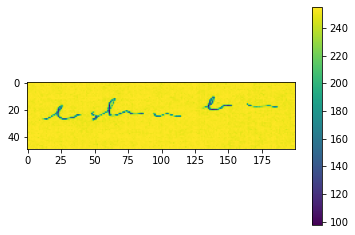

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

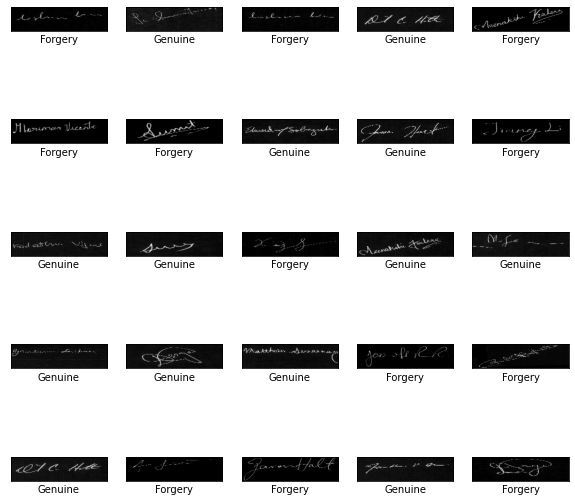

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels_og[i]])
plt.show()

In [14]:
model = keras.Sequential([
    keras.layers.Conv2D(16, kernel_size=3, activation='relu'),
    keras.layers.ReLU(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.LayerNormalization(),
    
    keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    keras.layers.ReLU(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.LayerNormalization(),
    
    keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    keras.layers.ReLU(),
    keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.LayerNormalization(),
    
    keras.layers.Conv2D(128, kernel_size=3, activation='relu'),
    keras.layers.ReLU(),
    #keras.layers.AveragePooling2D(pool_size=2),
    keras.layers.LayerNormalization(),
    
    keras.layers.Flatten(input_shape=(50, 200)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
    
    keras.layers.ReLU(),
    keras.layers.Dropout(0.05),
    
    #keras.layers.Flatten(input_shape=(50, 200)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy'])

In [16]:
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
63/63 [==============================] - 16s 225ms/step - loss: 0.6941 - categorical_crossentropy: 0.6941
Epoch 2/3
63/63 [==============================] - 14s 229ms/step - loss: 0.6944 - categorical_crossentropy: 0.6944
Epoch 3/3
63/63 [==============================] - 14s 226ms/step - loss: 0.6933 - categorical_crossentropy: 0.6933


In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

20/20 - 2s - loss: 0.6958 - categorical_crossentropy: 0.6958

Test accuracy: 0.6958156824111938


In [18]:
predictions = model.predict(test_images)

In [19]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

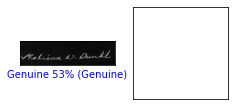

In [20]:
num_rows = 10
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels_og, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels_og)
plt.show()